id – id клиента в эксперименте
group – в каком разрешении показывались картинки:
+ A – прямоугольные 16:9 
+ B – квадратные 
+ C – прямоугольные 12:4
events – сколько блюд суммарно было заказано за период

In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
df_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-varenichenko-22/My_practice/Modul_6_Statistics/5_task_1.csv')

In [5]:
df_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [6]:
df_1.describe()

,id,events
count,30000.000000,30000.000000
mean,14999.500000,31.554500
std,8660.398374,10.878761
min,0.000000,-7.000000
25%,7499.750000,24.000000
50%,14999.500000,31.000000
75%,22499.250000,39.000000
max,29999.000000,75.000000


In [7]:
# Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.
#через pingouin
pg.homoscedasticity(data=df_1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


In [16]:
# Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. 
# Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), 
# так как на больших выборках могут получаться неверные результаты. 
sample_A = df_1.query("group == 'A'").events.sample(1000, random_state=17)
sample_B = df_1.query("group == 'B'").events.sample(1000, random_state=17)
sample_C = df_1.query("group == 'C'").events.sample(1000, random_state=17)

print(ss.shapiro(sample_A))
print(ss.shapiro(sample_B))
print(ss.shapiro(sample_C))


ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)
ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)


Значения во всех группах распределены нормально

In [17]:
# Дополнительно попробуем посчитать тест Шапиро-Уилка без использования метода sample. 
A = df_1.query("group == 'A'").events
B = df_1.query("group == 'B'").events
C = df_1.query("group == 'C'").events

print(ss.shapiro(A))
print(ss.shapiro(B))
print(ss.shapiro(C))

ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)
ShapiroResult(statistic=0.9990161061286926, pvalue=1.0504894817131571e-05)
ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Без применения метода sample() все распределения не являются нормальными 

In [24]:
# Сравним результаты с normaltest, а также qq-графиками
pg.normality(data=df_1, dv="events", group="group", method="normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


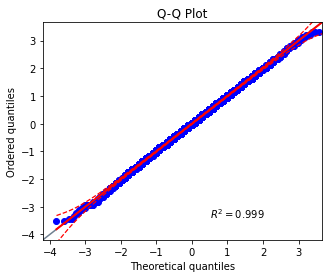

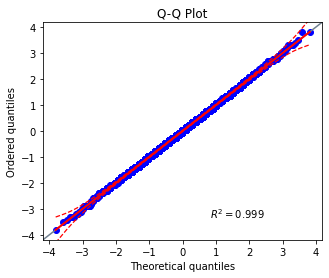

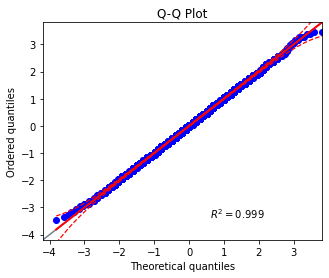

In [25]:
pg.qqplot(A)
pg.qqplot(B)
pg.qqplot(C)

Таким образом, на основании тестов Шапиро-Уилка (с поправкой на размер выборки), normaltest и qq-графиков все данные в группах распределены нормально

In [28]:
pg.welch_anova(data=df_1, dv="events", between = "group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,19996.209267,2924.792424,0.0,0.161377


In [29]:
#Для сравнения средних используем тест anova, так как соблюдены условия нормальности и гомогенности дисперсии
pg.anova(data=df_1, dv="events", between = "group")

#через scipy.stats
# ss.f_oneway(A, B, C)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [33]:
# C помощью критерия Тьюки посмотрим между какими группами есть статистически значимые различия.

pg.pairwise_tukey(data=df_1, dv="events", between = "group")

# Все группы попарно стат значимо отличаются
# стандартизованная разница в средних под названием Hedges

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


Различия между всеми тремя группами значимы. Итого, лучше всего выбрать группу B - у такой группы наибольшее среднее значение events

In [34]:
MultiComparison(df_1.events, df_1.group).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Проверим другие варианты поправок на множественные сравнения

In [36]:
#с поправкой Бонферрони
pg.pairwise_ttests(data=df_1, dv="events", between = "group", padjust="holm")

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


In [37]:
#попарные сравнения без поправки
pg.pairwise_ttests(data=df_1, dv="events", between = "group")

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,inf,1.024138


Во втором эксперименте проверим, как пользователи отреагируют на изменение формата кнопки оформления заказа, 
с разбивкой по сегменту клиента с помощью многофакторного дисперсионного анализа

In [2]:
df_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-varenichenko-22/My_practice/Modul_6_Statistics/5_task_2.csv')
df_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


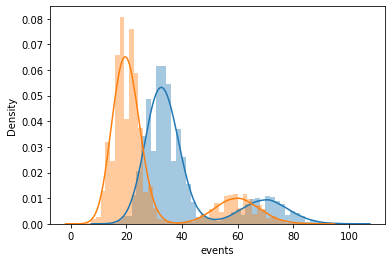

In [47]:
# Посмотрим на данные. Визуализируем распределение events для контрольной и тестовой групп. 
sns.distplot(df_2[df_2['group'] == 'test']['events'])
sns.distplot(df_2[df_2['group'] == 'control']['events'])

In [13]:
# Посvjnhbv среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

df_2.groupby(['group','segment']).agg({'events':['mean','median','std']})

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

Проверим эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

In [56]:
pg.anova(data=df_2, dv="events", between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [57]:
model_interact = smf.ols("events ~ segment + group + segment:group", data=df_2).fit()
anova_lm(model_interact, typ = 2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [3]:
df_2['combination'] = df_2.group + '\\' + df_2.segment
df_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


In [4]:
MultiComparison(df_2.events, df_2.combination).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control\high,control\low,-39.9392,0.001,-40.1073,-39.7711,True
control\high,test\high,9.9677,0.001,9.7551,10.1803,True
control\high,test\low,-26.9449,0.001,-27.113,-26.7768,True
control\low,test\high,49.9069,0.001,49.7388,50.075,True
control\low,test\low,12.9944,0.001,12.888,13.1007,True
test\high,test\low,-36.9126,0.001,-37.0807,-36.7445,True


In [5]:
pg.pairwise_tukey(data=df_2, dv="events", between = "combination")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


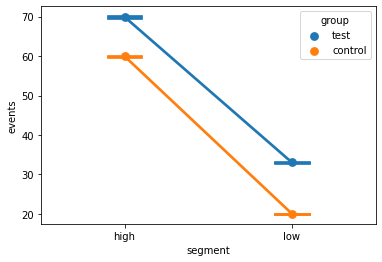

In [6]:
#взаимодействие
sns.pointplot(x="segment", y="events", hue="group", data=df_2, capsize=0.2)

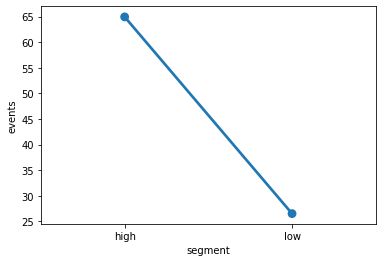

In [7]:
#первый фактор

sns.pointplot(x="segment", y="events", data=df_2)

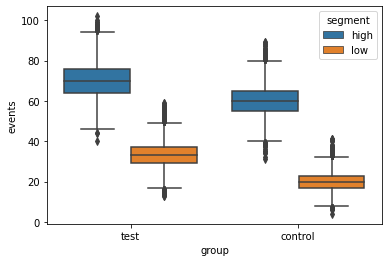

In [12]:
#второй фактор

sns.boxplot(data = df_2, x='group', y='events', hue='segment')

Факторы group, segment и их взаимодействие оказались значимы. 
Для всех групп среднее значение events увеличилось, поэтому можно принять изменение